# Unificando bases de datos

In [1]:
#0. Cargar las librerias 
from __future__ import print_function, division
import time
import nilmtk

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (13, 6)

In [2]:
# Tamaño de las secuencias de datos de entrada
sequence_length = 256

In [3]:
# Directorio general a las bases de datos
dir_redd = 'C:\\Users\\josel\\nilmtk_work\\NILMTK_Repaso\\redd_low_frec\\'

# House_1 

In [4]:
labels_h1 = pd.read_csv(dir_redd+'house_1\\labels.csv', sep=r' ', header = None, index_col=0)
labels_h1

,1
0,
0,main_1
1,main_2
2,fridge_1
3,dish washer_1
4,sockets_1
5,sockets_2
6,light_1
7,microwave_1
8,unknown_1


In [5]:
# Cargar los datos ya pre procesados para tener una misma frecuencia
main_1 = pd.read_csv(dir_redd+'house_1\\channel_1.csv', sep=r' ', header = None, index_col=0, parse_dates=True)
fridge_1 = pd.read_csv(dir_redd+'house_1\\channel_3.csv', sep=r' ', header = None, index_col=0, parse_dates=True)

In [6]:
main_2 = pd.read_csv(dir_redd+'house_1\\channel_2.csv', sep=r' ', header = None, index_col=0, parse_dates=True)

In [7]:
#Definir datos de entrenamiento y test hasta la fechas indicadas
train_main = main_1.loc[:'2011-4-29',1]
train_fridge_1 = fridge_1.loc[:'2011-4-29',1]

test_main = main_1.loc['2011-4-30':,1]
test_fridge_1 = fridge_1.loc['2011-4-30':,1]

print(f"train_main     {train_main.shape}")
print(f"train_fridge_1 {train_fridge_1.shape}")
print(f"test_main      {test_main.shape}")
print(f"test_fridge_1  {test_fridge_1.shape}")

train_main     (1003071,)
train_fridge_1 (1003067,)
test_main      (2131023,)
test_fridge_1  (2130995,)


In [8]:
# Calcular el valor maximo del medidor central con datos de train
mmax = None
if mmax == None:
    mmax = train_main.max()
print(mmax)

# Funciones para normalizar los datos
# Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _normalize(chunk, mmax):
    tchunk = chunk / mmax
    return tchunk

# Des Normaliza las series de tiempo teniendo en cuenta el valor maximo
# mmax medido por el medidor central
def _denormalize(chunk, mmax):
    tchunk = chunk * mmax
    return tchunk

4521.04


In [9]:
# Normaliza las series y guardarlas en variable nueva
mainchunk = _normalize(train_main, mmax)
meterchunk = _normalize(train_fridge_1, mmax)
mainchunk.head(5)

0
2011-04-18 09:22:09-04:00    0.049588
2011-04-18 09:22:10-04:00    0.049893
2011-04-18 09:22:11-04:00    0.050008
2011-04-18 09:22:12-04:00    0.049267
2011-04-18 09:22:13-04:00    0.049148
Name: 1, dtype: float64

In [10]:
#9. Tamaño de la secuencia definida para el modelo
s = sequence_length
#10. Remplaza valores NaNs con 0s
mainchunk.fillna(0, inplace=True)
meterchunk.fillna(0, inplace=True)

In [11]:
#11. Une los indices comunes a las dos series de dispositivo y medidor
# Retorna una serie con los indices comunes en fechas
ix = mainchunk.index.intersection(meterchunk.index)
print(ix)

DatetimeIndex(['2011-04-18 09:22:13-04:00', '2011-04-18 09:22:14-04:00',
               '2011-04-18 09:22:15-04:00', '2011-04-18 09:22:16-04:00',
               '2011-04-18 09:22:17-04:00', '2011-04-18 09:22:18-04:00',
               '2011-04-18 09:22:19-04:00', '2011-04-18 09:22:20-04:00',
               '2011-04-18 09:22:21-04:00', '2011-04-18 09:22:22-04:00',
               ...
               '2011-04-29 23:59:50-04:00', '2011-04-29 23:59:51-04:00',
               '2011-04-29 23:59:52-04:00', '2011-04-29 23:59:53-04:00',
               '2011-04-29 23:59:54-04:00', '2011-04-29 23:59:55-04:00',
               '2011-04-29 23:59:56-04:00', '2011-04-29 23:59:57-04:00',
               '2011-04-29 23:59:58-04:00', '2011-04-29 23:59:59-04:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-240)]', name=0, length=1003067, freq='S')


In [12]:
#11. Toma los datos en las fechas coincidentes y descarta las demas
# seleccionando por medio de los indices contenidos en ix
mainchunk = mainchunk[ix]
meterchunk = meterchunk[ix]

In [13]:
#12. Tamaño del batch de ceros
adicion = s - (len(ix) % s)
#A cada serie de medidor se le agrega el batch
#Se definen en función del tamaño de la muestra
#Esta operación elimina el indice de tipo tiempo
X_batch = np.append(mainchunk, np.zeros(adicion))    # Medidor central
Y_batch = np.append(meterchunk, np.zeros(adicion))   # Medidor de dispositivo

In [14]:
#13. Cambia la forma de los datos quedando la señal en tramos de 256 puntos chunk
#Para el ventanas de 256 seran (muestras = 3919, ventana = 256, Caracteristica = 1)
X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s, 1))
Y_batch = np.reshape(Y_batch, (int(len(Y_batch) / s), s, 1))
print(f"X_batch {X_batch.shape}")
print(f"Y_batch {Y_batch.shape}")

X_batch (3919, 256, 1)
Y_batch (3919, 256, 1)


In [15]:
print(f"X_batch {type(X_batch)}")
print(f"Y_batch {type(Y_batch)}")

X_batch <class 'numpy.ndarray'>
Y_batch <class 'numpy.ndarray'>


# Modelos

En esta sección se definen los diferentes modelos con los que se entrenaran los datos teniendo como objetivo predecir el consumo de un unico dispositivo. 

Tenga en cuenta que el numero de pasos de entrada debe ser la misma que el tamaño de la serie de salida. Esto se debe a que la logica implementada es que con las medidas tomadas por el medidor central se calcule el consumo en el mismo instante de tiempo para el medidor del dispositivo.

In [16]:
# Librerias para modelos
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Reshape, Dropout
from keras.utils import plot_model

# univariate multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [17]:
def auto_encoder1(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(8, 4, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    
    #Auto encoder
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [18]:
dae = auto_encoder1(sequence_length)

In [51]:
# train the model
#def build_model(train, n_input):
def build_model1(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [54]:
bm1 = build_model1(sequence_length)

In [62]:
def build_model2(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [63]:
bm2 = build_model2(sequence_length)

In [64]:
def build_model3(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [65]:
bm3 = build_model3(sequence_length)

In [104]:
def build_model4(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [105]:
bm4 = build_model4(sequence_length)

In [68]:
def build_model5(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    #model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding="same", strides=1))
    #model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))

    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [69]:
bm5 = build_model5(sequence_length)

In [121]:
def build_model6(sequence_len):    

    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_len,1), padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding="same", strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    #model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding="same", strides=1))
    #model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))

    model.add(Dense(sequence_len))
    model.compile(loss='mse', optimizer='adam')

    return model

In [122]:
bm6 = build_model6(sequence_length)

In [129]:
def build_model7(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(32, 6, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Conv1D(8, 4, activation="linear", padding="same", strides=1))
    #Aplanar la salida
    model.add(Flatten())
    # Fully Connected Layers abandono del 20%
    model.add(Dropout(0.2))
    
    #Auto encoder
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 4, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [130]:
bm7 = build_model7(sequence_length)

In [154]:
def build_model8(sequence_len):
    '''Crear el modulo Auto encoder descrito en el articulo
    '''
    #Crea el contenedor del modelo
    model = Sequential()

    # 1D Conv filtros = 8, kernel = 4, entrada 256 pasos de 1 feature, padding igual, paso en 1
    model.add(Conv1D(64, 9, activation="linear", input_shape=(sequence_len, 1), padding="same", strides=1))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 4, activation="linear", padding="same", strides=1))
    model.add(Dropout(0.2))
    #Aplanar la salida
    model.add(Flatten())

    
    #Auto encoder
    # Neuronas 8 veces el tamaño de la ventana de tiempo = 2048 nodos
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    #Abandono del 20% capa con 128 neuronas
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    #Abandono del 20% capa con 2048 nodos
    model.add(Dropout(0.2))
    
    model.add(Dense((sequence_len-0)*8, activation='relu'))
    model.add(Dropout(0.2))

    # 1D Conv
    # La salida de la capa anterior es una secuencia aplanada. Es necesario cambiar
    # el formato de los datos de salida para obtener datos de forma 256,8 similar
    # a los pasos y filtros de la primer convolución
    model.add(Reshape(((sequence_len-0), 8)))
    model.add(Dropout(0.2))
    #Entrega estos datos a una nueva capa convolucional 1 filtro con kernel = 4
    #Supongo es de un solo filtro debido a que deseamos obtener una sola serie. 
    model.add(Conv1D(1, 3, activation="linear", padding="same", strides=1))
    #Compila el modelo con perdida mse y optimizador de adam
    model.compile(loss='mse', optimizer='adam')
    #Grafico del modelo para exportar
    #plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [155]:
bm8 = build_model8(sequence_length)

## Entrenar modelos

### Modelo 0

In [35]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_entrenado = dae.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 5s 37ms/step - loss: 4.1209e-04
Epoch 2/25
123/123 [==============================] - 5s 40ms/step - loss: 2.6158e-04
Epoch 3/25
123/123 [==============================] - 5s 38ms/step - loss: 2.3997e-04
Epoch 4/25
123/123 [==============================] - 5s 38ms/step - loss: 2.3641e-04
Epoch 5/25
123/123 [==============================] - 5s 38ms/step - loss: 2.2828e-04
Epoch 6/25
123/123 [==============================] - 5s 37ms/step - loss: 2.1447e-04
Epoch 7/25
123/123 [==============================] - 5s 37ms/step - loss: 2.2945e-04
Epoch 8/25
123/123 [==============================] - 5s 39ms/step - loss: 2.2565e-04
Epoch 9/25
123/123 [==============================] - 5s 41ms/step - loss: 2.2083e-04
Epoch 10/25
123/123 [==============================] - 5s 39ms/step - loss: 2.0503e-04
Epoch 11/25
123/123 [==============================] - 5s 39ms/step - loss: 2.0809e-04
Epoch 12/25
123/123 [==============================]

In [36]:
dae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 8)            40        
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

### MODELO UNO

In [55]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm1 = bm1.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 1s 4ms/step - loss: 4.0429e-04
Epoch 2/25
123/123 [==============================] - 0s 4ms/step - loss: 2.5402e-04
Epoch 3/25
123/123 [==============================] - 0s 4ms/step - loss: 2.4606e-04
Epoch 4/25
123/123 [==============================] - 0s 4ms/step - loss: 2.3666e-04
Epoch 5/25
123/123 [==============================] - 0s 4ms/step - loss: 2.3388e-04
Epoch 6/25
123/123 [==============================] - 0s 4ms/step - loss: 2.1523e-04
Epoch 7/25
123/123 [==============================] - 0s 4ms/step - loss: 2.0369e-04
Epoch 8/25
123/123 [==============================] - 0s 4ms/step - loss: 1.8417e-04
Epoch 9/25
123/123 [==============================] - 0s 3ms/step - loss: 1.9188e-04
Epoch 10/25
123/123 [==============================] - 0s 3ms/step - loss: 1.8451e-04
Epoch 11/25
123/123 [==============================] - 0s 3ms/step - loss: 1.8376e-04
Epoch 12/25
123/123 [==============================] - 0s 3ms/s

### MODELO DOS

In [76]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm2 = bm2.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 1s 5ms/step - loss: 3.7940e-04
Epoch 2/25
123/123 [==============================] - 1s 4ms/step - loss: 2.5930e-04
Epoch 3/25
123/123 [==============================] - 1s 4ms/step - loss: 2.2766e-04
Epoch 4/25
123/123 [==============================] - 1s 4ms/step - loss: 2.2701e-04
Epoch 5/25
123/123 [==============================] - 1s 4ms/step - loss: 2.3676e-04
Epoch 6/25
123/123 [==============================] - 1s 4ms/step - loss: 2.0905e-04
Epoch 7/25
123/123 [==============================] - 1s 5ms/step - loss: 2.0849e-04
Epoch 8/25
123/123 [==============================] - 1s 5ms/step - loss: 1.9871e-04
Epoch 9/25
123/123 [==============================] - 1s 4ms/step - loss: 1.8371e-04
Epoch 10/25
123/123 [==============================] - 1s 5ms/step - loss: 1.9068e-04
Epoch 11/25
123/123 [==============================] - 1s 6ms/step - loss: 1.7247e-04
Epoch 12/25
123/123 [==============================] - 1s 5ms/s

### MODELO TRES

In [84]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm3 = bm3.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 1s 6ms/step - loss: 4.0345e-04
Epoch 2/25
123/123 [==============================] - 1s 6ms/step - loss: 2.5110e-04
Epoch 3/25
123/123 [==============================] - 1s 6ms/step - loss: 2.4431e-04
Epoch 4/25
123/123 [==============================] - 1s 6ms/step - loss: 2.2221e-04
Epoch 5/25
123/123 [==============================] - 1s 6ms/step - loss: 2.0833e-04
Epoch 6/25
123/123 [==============================] - 1s 6ms/step - loss: 2.1450e-04
Epoch 7/25
123/123 [==============================] - 1s 6ms/step - loss: 1.8506e-04
Epoch 8/25
123/123 [==============================] - 1s 6ms/step - loss: 1.7897e-04
Epoch 9/25
123/123 [==============================] - 1s 6ms/step - loss: 1.9543e-04
Epoch 10/25
123/123 [==============================] - 1s 6ms/step - loss: 1.8200e-04
Epoch 11/25
123/123 [==============================] - 1s 6ms/step - loss: 1.8006e-04
Epoch 12/25
123/123 [==============================] - 1s 6ms/s

### MODELO CUATRO

In [106]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm4 = bm4.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 2s 11ms/step - loss: 3.6634e-04
Epoch 2/25
123/123 [==============================] - 1s 10ms/step - loss: 2.4765e-04
Epoch 3/25
123/123 [==============================] - 1s 11ms/step - loss: 2.3483e-04
Epoch 4/25
123/123 [==============================] - 1s 11ms/step - loss: 2.2884e-04
Epoch 5/25
123/123 [==============================] - 1s 11ms/step - loss: 2.2377e-04
Epoch 6/25
123/123 [==============================] - 1s 11ms/step - loss: 2.3425e-04
Epoch 7/25
123/123 [==============================] - 1s 12ms/step - loss: 2.2246e-04
Epoch 8/25
123/123 [==============================] - 1s 11ms/step - loss: 1.9273e-04
Epoch 9/25
123/123 [==============================] - 1s 11ms/step - loss: 1.7487e-04
Epoch 10/25
123/123 [==============================] - 1s 11ms/step - loss: 2.0108e-04
Epoch 11/25
123/123 [==============================] - 1s 10ms/step - loss: 1.7959e-04
Epoch 12/25
123/123 [==============================]

### MODELO CINCO

In [114]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm5 = bm5.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 2s 12ms/step - loss: 4.0818e-04
Epoch 2/25
123/123 [==============================] - 2s 12ms/step - loss: 2.7128e-04
Epoch 3/25
123/123 [==============================] - 2s 13ms/step - loss: 2.4619e-04
Epoch 4/25
123/123 [==============================] - 2s 12ms/step - loss: 2.2012e-04
Epoch 5/25
123/123 [==============================] - 2s 13ms/step - loss: 2.3291e-04
Epoch 6/25
123/123 [==============================] - 2s 13ms/step - loss: 2.2429e-04
Epoch 7/25
123/123 [==============================] - 2s 13ms/step - loss: 2.1163e-04
Epoch 8/25
123/123 [==============================] - 2s 13ms/step - loss: 2.0920e-04
Epoch 9/25
123/123 [==============================] - 2s 13ms/step - loss: 1.9897e-04
Epoch 10/25
123/123 [==============================] - 2s 13ms/step - loss: 2.0988e-04
Epoch 11/25
123/123 [==============================] - 2s 13ms/step - loss: 2.0463e-04
Epoch 12/25
123/123 [==============================]

### MODELO SEIS

In [123]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm6 = bm6.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 1s 8ms/step - loss: 4.0298e-04
Epoch 2/25
123/123 [==============================] - 1s 8ms/step - loss: 2.6583e-04
Epoch 3/25
123/123 [==============================] - 1s 8ms/step - loss: 2.4739e-04
Epoch 4/25
123/123 [==============================] - 1s 8ms/step - loss: 2.1876e-04
Epoch 5/25
123/123 [==============================] - 1s 8ms/step - loss: 2.0689e-04
Epoch 6/25
123/123 [==============================] - 1s 8ms/step - loss: 2.1360e-04
Epoch 7/25
123/123 [==============================] - 1s 8ms/step - loss: 1.9617e-04
Epoch 8/25
123/123 [==============================] - 1s 9ms/step - loss: 2.0393e-04
Epoch 9/25
123/123 [==============================] - 1s 8ms/step - loss: 1.8653e-04
Epoch 10/25
123/123 [==============================] - 1s 8ms/step - loss: 1.8159e-04
Epoch 11/25
123/123 [==============================] - 1s 8ms/step - loss: 1.8379e-04
Epoch 12/25
123/123 [==============================] - 1s 9ms/s

### MODELO SIETE

In [131]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm7 = bm7.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 6s 47ms/step - loss: 3.4578e-04
Epoch 2/25
123/123 [==============================] - 6s 47ms/step - loss: 2.8580e-04
Epoch 3/25
123/123 [==============================] - 6s 47ms/step - loss: 2.3567e-04
Epoch 4/25
123/123 [==============================] - 6s 51ms/step - loss: 2.4282e-04
Epoch 5/25
123/123 [==============================] - 6s 48ms/step - loss: 2.4672e-04
Epoch 6/25
123/123 [==============================] - 6s 48ms/step - loss: 2.2791e-04
Epoch 7/25
123/123 [==============================] - 6s 46ms/step - loss: 2.2426e-04
Epoch 8/25
123/123 [==============================] - 6s 47ms/step - loss: 2.0452e-04
Epoch 9/25
123/123 [==============================] - 6s 47ms/step - loss: 2.1825e-04
Epoch 10/25
123/123 [==============================] - 6s 47ms/step - loss: 2.1864e-04
Epoch 11/25
123/123 [==============================] - 6s 46ms/step - loss: 2.0602e-04
Epoch 12/25
123/123 [==============================]

### MODELO OCHO

In [156]:
train_mains = X_batch 
train_meter = Y_batch 
modelo_bm8 = bm8.fit(train_mains, train_meter, epochs=25)

Epoch 1/25
123/123 [==============================] - 11s 82ms/step - loss: 4.0877e-04
Epoch 2/25
123/123 [==============================] - 10s 82ms/step - loss: 3.0074e-04
Epoch 3/25
123/123 [==============================] - 10s 84ms/step - loss: 3.1550e-04
Epoch 4/25
123/123 [==============================] - 10s 80ms/step - loss: 3.3674e-04
Epoch 5/25
123/123 [==============================] - 10s 81ms/step - loss: 2.5977e-04
Epoch 6/25
123/123 [==============================] - 10s 81ms/step - loss: 2.5982e-04
Epoch 7/25
123/123 [==============================] - 10s 81ms/step - loss: 2.4672e-04
Epoch 8/25
123/123 [==============================] - 10s 81ms/step - loss: 2.3699e-04
Epoch 9/25
123/123 [==============================] - 10s 81ms/step - loss: 2.5790e-04
Epoch 10/25
123/123 [==============================] - 10s 81ms/step - loss: 2.6837e-04
Epoch 11/25
123/123 [==============================] - 10s 80ms/step - loss: 2.1955e-04
Epoch 12/25
123/123 [====================

# Datos de Test

In [37]:
test_main = main_1.loc['2011-4-30':,1]
test_fridge_1 = fridge_1.loc['2011-4-30':,1]
print(f"test_main      {test_main.shape}")
print(f"test_fridge_1  {test_fridge_1.shape}")

test_main      (2131023,)
test_fridge_1  (2130995,)


In [38]:
#Selecciona el medidor central del edificio
test_mains = test_main
test_meter = test_fridge_1

Datos de test deben ser evaluados en los instantes de tiempo donde el medidor central funciono de manera idonea. Esto con el fin de evaluar los datos en instantes de buen registro de datos.

In [39]:
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Carga los datos completos
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
# Define el tamaño de la muestra de test iniciando justo donde termina el train
test.set_window(start="30-4-2011") 
# Selecciona los electrodomesticos del primer edificio
test_elec = test.buildings[1].elec
# Selecciona el medidor central del edificio
test_mains_1 = test_elec.mains().all_meters()[0]
test_meter_1 = test_elec.submeters()['fridge']
good_sections = test_mains_1.good_sections()
good_sections

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

[TimeFrame(start='2011-04-30 00:00:00-04:00', end='2011-05-01 09:44:42-04:00', empty=False),
 TimeFrame(start='2011-05-01 09:47:18-04:00', end='2011-05-02 17:04:59-04:00', empty=False),
 TimeFrame(start='2011-05-02 17:07:27-04:00', end='2011-05-03 17:30:17-04:00', empty=False),
 TimeFrame(start='2011-05-03 17:32:49-04:00', end='2011-05-03 17:33:44-04:00', empty=False),
 TimeFrame(start='2011-05-06 10:51:46-04:00', end='2011-05-07 01:53:10-04:00', empty=False),
 TimeFrame(start='2011-05-07 01:53:55-04:00', end='2011-05-07 02:38:15-04:00', empty=False),
 TimeFrame(start='2011-05-07 02:40:43-04:00', end='2011-05-07 11:59:16-04:00', empty=False),
 TimeFrame(start='2011-05-11 03:19:43-04:00', end='2011-05-12 17:48:38-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:14:30-04:00', end='2011-05-13 05:16:24-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:04:46-04:00', end='2011-05-22 23:39:01-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:41:35-04:00', end='2011-05-23 09:22:08

In [40]:
#18. Define un array para timeframes vacio en este almacenare
# los tiempos donde el medidor estaba en buen funcionamiento
timeframes = []

In [41]:
def data_predict(mains, modelo):
    #Cantidad de pasos en la ventana
    s = sequence_length
    # Tamaño de la sección de la serie que se cargada
    # según los instantes de buen funcionamiento del medidor
    up_limit = len(mains)
    # Rellenar los valores Nan con ceros
    mains.fillna(0, inplace=True)
    # Calcular la cantidad de ceros que deben llenarse 
    # para crear un batch que permita que los datos al 
    # dividirse mantengan el tamaño para todos los datos
    additional = s - (up_limit % s)
    # Crear series de datos con los batch de ceros al final
    X_batch = np.append(mains, np.zeros(additional))
    #Cambiar el formato de los datos como: numero de muestras
    # ventanas de tiempo = 256, y una caracteristica
    X_batch = np.reshape(X_batch, (int(len(X_batch) / s), s ,1))
    #Calcular la prediccion para el modelo
    #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    pred = modelo.predict(X_batch)
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # Ahora une todas las salidas en ventanas a una serie completa, de los cuales solo toma
    # los datos hasta donde la serie original tenia datos. Los datos restantes
    # son los tomados por el batch de ceros, por lo tanto, se eliminan de la predicción
    pred = np.reshape(pred, (up_limit + additional))[:up_limit]
    # Crea una serie de pandas, con los datos de pred, usa como indice los mismos indices de 
    # tiempo que tenia la serie original y como nombre la llama 0 este es un metadato
    column = pd.Series(pred, index=mains.index, name=0)

    # Crea un diccionario vacio con el creara un dataframe posteriormente
    # donde la clave key = 0 tendra como valor value la columna de datos predichos
    appliance_powers_dict = {}
    appliance_powers_dict[0] = column
    # Transforma el diccionario a un dataframe de pandas de esta manera 
    # agrega la dimension de las columnas = 1. Tal que (muestras, 1)
    appliance_powers = pd.DataFrame(appliance_powers_dict)
    # Y es este dataframe el que retorna
    return appliance_powers

In [42]:
# Recorre cada sección de datos
# hace los cortes para cada sección en los datos de test
# Hace la predicción para dicha sección 
# Retorna los datos y los concatenta
# Guarda todas las medidas resultantes en un archivo hdf5 output_datastore
def process_test(good_sections, test_mains, test_appliance, model, output_datastore, sequence_length = 256):
    #23. Defino una lista que contendra los instantes de buen funcionamiento 
    # que cumplan con el tamaño de muestra
    timeframes = []
    for good_section in good_sections:
        # Recortar las secciones
        #print(i.start)
        #print(i.end)
        chunk = test_mains.loc[good_section.start:good_section.end]
        chunk_test = test_appliance.loc[good_section.start:good_section.end]
        #print(f"chunk {chunk.shape}")
        #print(f"chunk_test {chunk_test.shape}")

        # Si el tamaño de la serie cargada es menor al de las ventanas se descarta
        if len(chunk) < sequence_length:
            continue
        #26. Imprime el tamaño de los tramos de series cargados
        print("New sensible chunk: {} size of data".format(len(chunk)))

        # Se guarda cada tramo de tiempo seleccionado
        timeframes.append(chunk.index)
        # Serie normalizada para test
        chunk2 = _normalize(chunk, mmax)
        # llamar funcion, pasar chunk2 
        appliance_power = data_predict(chunk2, model)

        # Todo valor negativo calculado lo iguala a cero
        appliance_power[appliance_power < 0] = 0

        # Calcula el valor real mediante la desnormalización de los datos
        appliance_power = _denormalize(appliance_power, mmax)

        cols = ['power']
        # Test                  
        df1 = pd.DataFrame(
            chunk_test.values, index=chunk_test.index,
            columns=cols, dtype="float32")
        # Predict
        df2 = pd.DataFrame(
            appliance_power.values, index=appliance_power.index,
            columns=cols, dtype="float32")

        key1 = 'fridge_test'
        output_datastore.append(key1, df1)
        key2 = 'fridge_predict'
        output_datastore.append(key2, df2)

### MODELO 0 DAE

In [43]:
output_datastore = pd.HDFStore("borrar_0", "w")
#output_datastore.close()

In [44]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, dae, output_datastore, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


In [45]:
output_datastore.keys()

['/fridge_predict', '/fridge_test']

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


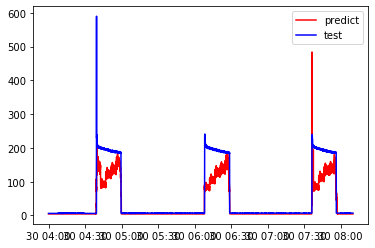

In [45]:
plt.plot(output_datastore.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**Correlación**

In [200]:
#Calculo de correlación cruzada
predict0 = output_datastore.get('/fridge_predict')
test0 = output_datastore.get('/fridge_test')
print(predict0.shape)
t0 = np.ravel(test0)
p0 = np.ravel(predict0)
print(len(t0))
np.corrcoef(t0,p0)

(746149, 1)
746149


array([[1.        , 0.83290021],
       [0.83290021, 1.        ]])

In [202]:
print(f"Correlación {np.corrcoef(t0,p0)[0,1]}")

Correlación 0.8329002100271482


**Consumos total y promedio**

In [204]:
total_consumo_test0 = sum(t0)
promedio_test0 = total_consumo_test0 / len(t0)

total_consumo_pred0 = sum(p0)
promedio_pred0 = total_consumo_pred0 / len(p0)

print(f"Consumo test >>> TOTAL = {total_consumo_test0}               Promedio = {promedio_test0}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred0}        Promedio = {promedio_pred0}")

diferencia_total0 = total_consumo_test0 - total_consumo_pred0
print(f"Diferencias total:    {diferencia_total0}")

diferencia_promedio0 = promedio_test0 - promedio_pred0
print(f"Diferencias promedio: {diferencia_promedio0}")

Consumo test >>> TOTAL = 41746110.0               Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 35364748.77065284        Promedio = 47.39636288549986
Diferencias total:    6381361.229347162
Diferencias promedio: 8.552395338393758


### Modelo UNO resultados

In [56]:
output_datastore_1 = pd.HDFStore("borrar_m1", "w")
#output_datastore.close()

In [57]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm1, output_datastore_1, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


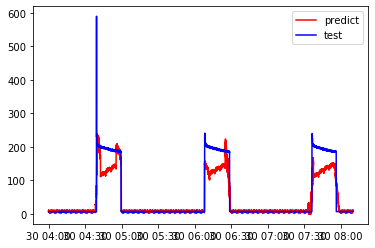

In [58]:
plt.plot(output_datastore_1.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_1.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [205]:
#Calculo de correlación cruzada
predict1 = output_datastore_1.get('/fridge_predict')
test1  = output_datastore_1.get('/fridge_test')
print(predict1.shape)
t1 = np.ravel(test0)
p1 = np.ravel(predict0)
print(len(t1))
np.corrcoef(t1,p1)
print(f"Correlación {np.corrcoef(t1,p1)}")

(746149, 1)
746149
Correlación [[1.         0.83290021]
 [0.83290021 1.        ]]


**Potencia promedio de consumo**

In [206]:
total_consumo_test1 = sum(t1)
promedio_test1 = total_consumo_test1 / len(t1)

total_consumo_pred1 = sum(p1)
promedio_pred1 = total_consumo_pred1 / len(p1)

print(f"Consumo test >>> TOTAL = {total_consumo_test1}               Promedio = {promedio_test1}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred1}        Promedio = {promedio_pred1}")

diferencia_total1 = total_consumo_test1 - total_consumo_pred1
print(f"Diferencias total:    {diferencia_total1}")

diferencia_promedio1 = promedio_test1 - promedio_pred1
print(f"Diferencias promedio: {diferencia_promedio1}")

Consumo test >>> TOTAL = 41746110.0               Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 35364748.77065284        Promedio = 47.39636288549986
Diferencias total:    6381361.229347162
Diferencias promedio: 8.552395338393758


###  Modelo DOS resultados

In [77]:
output_datastore_2 = pd.HDFStore("borrar_m2", "w")
#output_datastore.close()

In [78]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm2, output_datastore_2, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


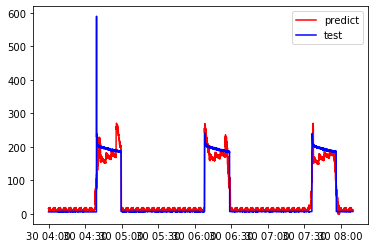

In [79]:
plt.plot(output_datastore_2.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_2.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [208]:
#Calculo de correlación cruzada
predict2 = output_datastore_2.get('/fridge_predict')
test2  = output_datastore_2.get('/fridge_test')
print(predict2.shape)
t2 = np.ravel(test2)
p2 = np.ravel(predict2)
print(len(t2))
np.corrcoef(t2,p2)


(746149, 1)
746149


array([[1.        , 0.87669782],
       [0.87669782, 1.        ]])

In [99]:
print(f"Correlación {np.corrcoef(t2,p2)[1,0]}")

Correlación 0.8766978154568823


**Potencia promedio de consumo**

In [209]:
total_consumo_test2 = sum(t2)
promedio_test2 = total_consumo_test2 / len(t2)

total_consumo_pred2 = sum(p2)
promedio_pred2 = total_consumo_pred2 / len(p2)

print(f"Consumo test >>> TOTAL = {total_consumo_test2}               Promedio = {promedio_test2}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred2}        Promedio = {promedio_pred2}")

diferencia_total2 = total_consumo_test2 - total_consumo_pred2
print(f"Diferencias total:    {diferencia_total2}")

diferencia_promedio2 = promedio_test2 - promedio_pred2
print(f"Diferencias promedio: {diferencia_promedio2}")

Consumo test >>> TOTAL = 41746110.0               Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 47464447.0019809        Promedio = 63.61255862030359
Diferencias total:    -5718337.001980901
Diferencias promedio: -7.663800396409968


### Modelo TRES resultados

In [85]:
output_datastore_3 = pd.HDFStore("borrar_m3", "w")
#output_datastore.close()

In [86]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm3, output_datastore_3, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


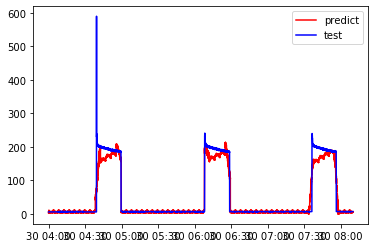

In [87]:
plt.plot(output_datastore_3.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_3.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [214]:
#Calculo de correlación cruzada
predict3 = output_datastore_3.get('/fridge_predict')
test3 = output_datastore_3.get('/fridge_test')
print(predict3.shape)
t3 = np.ravel(test3)
p3 = np.ravel(predict3)
print(len(t3))
np.corrcoef(t3,p3)


(746149, 1)
746149


array([[1.        , 0.85957337],
       [0.85957337, 1.        ]])

In [215]:
print(f"Correlación {np.corrcoef(t3,p3)[1,0]}")

Correlación 0.8595733679881972


**Potencia promedio de consumo**

In [219]:
total_consumo_test3 = sum(t3)
promedio_test3 = total_consumo_test3 / len(t3)

total_consumo_pred3 = sum(p3)
promedio_pred3 = total_consumo_pred3 / len(p3)

print(f"Consumo test >>> TOTAL = {total_consumo_test3}                Promedio = {promedio_test3}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred3}         Promedio = {promedio_pred3}")

diferencia_total3 = total_consumo_test3 - total_consumo_pred3
print(f"Diferencias total:    {diferencia_total3}")

diferencia_promedio3 = promedio_test3 - promedio_pred3
print(f"Diferencias promedio: {diferencia_promedio3}")

Consumo test >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 39287004.75410256         Promedio = 52.65302875712835
Diferencias total:    2459105.245897442
Diferencias promedio: 3.2957294667652732


### Modelo CUATRO resultados

In [109]:
output_datastore_4 = pd.HDFStore("borrar_m4", "w")
#output_datastore_4.close()

In [110]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm4, output_datastore_4, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


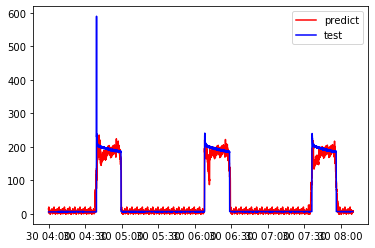

In [111]:
plt.plot(output_datastore_4.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_4.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [298]:
#Calculo de correlación cruzada
predict4 = output_datastore_4.get('/fridge_predict')
test4 = output_datastore_4.get('/fridge_test')
print(predict4.shape)
t4 = np.ravel(test4)
p4 = np.ravel(predict4)
print(len(t4))
np.corrcoef(t4,p4)


(746149, 1)
746149


array([[1.        , 0.88375848],
       [0.88375848, 1.        ]])

In [299]:
print(f"Correlación {np.corrcoef(t4,p4)[1,0]}")

Correlación 0.8837584839095108


**Potencia promedio de consumo**

In [300]:
total_consumo_test4 = sum(t4)
promedio_test4 = total_consumo_test4 / len(t4)

total_consumo_pred4 = sum(p4)
promedio_pred4 = total_consumo_pred4 / len(p4)

print(f"Consumo test >>> TOTAL = {total_consumo_test4}                Promedio = {promedio_test4}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred4}         Promedio = {promedio_pred4}")

diferencia_total4 = total_consumo_test4 - total_consumo_pred4
print(f"Diferencias total:    {diferencia_total4}")

diferencia_promedio4 = promedio_test4 - promedio_pred4
print(f"Diferencias promedio: {diferencia_promedio4}")

Consumo test >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 45120391.22648903         Promedio = 60.471020166868854
Diferencias total:    -3374281.22648903
Diferencias promedio: -4.522261942975234


### Modelo CINCO resultados

In [115]:
output_datastore_5 = pd.HDFStore("borrar_m5", "w")
#output_datastore_5.close()

In [116]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm5, output_datastore_5, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


In [117]:
output_datastore_5.keys()

['/fridge_predict', '/fridge_test']

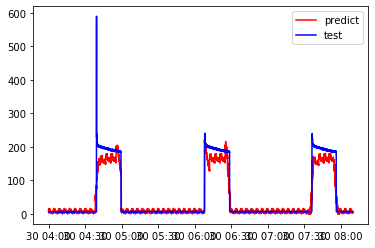

In [118]:
plt.plot(output_datastore_5.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_5.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [241]:
#Calculo de correlación cruzada
predict5 = output_datastore_5.get('/fridge_predict')
test5 = output_datastore_5.get('/fridge_test')
print(predict5.shape)
t5 = np.ravel(test5)
p5 = np.ravel(predict5)
print(len(t5))
np.corrcoef(t5,p5)


(746149, 1)
746149


array([[1.        , 0.87175547],
       [0.87175547, 1.        ]])

In [120]:
print(f"Correlación {np.corrcoef(t5,p5)[1,0]}")

Correlación 0.8717554667491473


**Potencia promedio de consumo**

In [242]:
total_consumo_test5 = sum(t5)
promedio_test5 = total_consumo_test5 / len(t5)

total_consumo_pred5 = sum(p5)
promedio_pred5 = total_consumo_pred5 / len(p5)

print(f"Consumo test >>> TOTAL = {total_consumo_test5}                Promedio = {promedio_test5}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred5}         Promedio = {promedio_pred5}")

diferencia_total5 = total_consumo_test5 - total_consumo_pred5
print(f"Diferencias total:    {diferencia_total5}")

diferencia_promedio5 = promedio_test5 - promedio_pred5
print(f"Diferencias promedio: {diferencia_promedio5}")

Consumo test >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 34813839.56605143         Promedio = 46.65802616642444
Diferencias total:    6932270.433948569
Diferencias promedio: 9.290732057469178


### Modelo SEIS resultados

In [124]:
output_datastore_6 = pd.HDFStore("borrar_m6", "w")
#output_datastore_6.close()

In [125]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm6, output_datastore_6, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


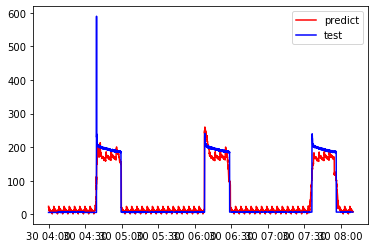

In [126]:
plt.plot(output_datastore_6.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_6.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [301]:
#Calculo de correlación cruzada
predict6 = output_datastore_6.get('/fridge_predict')
test6 = output_datastore_6.get('/fridge_test')
print(predict6.shape)
t6 = np.ravel(test6)
p6 = np.ravel(predict6)
print(len(t6))
np.corrcoef(t6,p6)


(746149, 1)
746149


array([[1.        , 0.87203677],
       [0.87203677, 1.        ]])

In [302]:
print(f"Correlación {np.corrcoef(t6,p6)[1,0]}")

Correlación 0.8720367700559856


**Potencia promedio de consumo**

In [303]:
total_consumo_test6 = sum(t6)
promedio_test6 = total_consumo_test6 / len(t6)

total_consumo_pred6 = sum(p6)
promedio_pred6 = total_consumo_pred6 / len(p6)

print(f"Consumo test >>> TOTAL = {total_consumo_test6}         Promedio = {promedio_test6}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred6}                Promedio = {promedio_pred6}")

diferencia_total6 = total_consumo_test6 - total_consumo_pred6
print(f"Diferencias total:    {diferencia_total6}")

diferencia_promedio6 = promedio_test6 - promedio_pred6
print(f"Diferencias promedio: {diferencia_promedio6}")

Consumo test >>> TOTAL = 41746110.0         Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 42639163.33209946                Promedio = 57.145641597186966
Diferencias total:    -893053.3320994601
Diferencias promedio: -1.1968833732933462


### Modelo SIETE resultados

In [132]:
output_datastore_7 = pd.HDFStore("borrar_m7", "w")
#output_datastore_7.close()

In [133]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm7, output_datastore_7, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


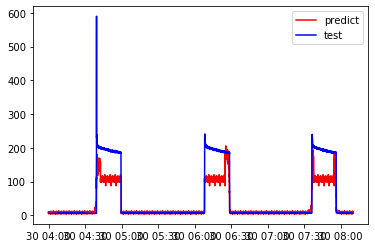

In [134]:
plt.plot(output_datastore_7.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_7.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [306]:
#Calculo de correlación cruzada
predict7 = output_datastore_7.get('/fridge_predict')
test7 = output_datastore_7.get('/fridge_test')
print(predict7.shape)
t7 = np.ravel(test7)
p7 = np.ravel(predict7)
print(len(t7))
np.corrcoef(t7,p7)


(746149, 1)
746149


array([[1.        , 0.79392924],
       [0.79392924, 1.        ]])

In [307]:
print(f"Correlación {np.corrcoef(t7,p7)[1,0]}")

Correlación 0.7939292401198401


**Potencia promedio de consumo**

In [308]:
total_consumo_test7 = sum(t7)
promedio_test7 = total_consumo_test7 / len(t7)

total_consumo_pred7 = sum(p7)
promedio_pred7 = total_consumo_pred7 / len(p7)

print(f"Consumo test >>> TOTAL = {total_consumo_test7}         Promedio = {promedio_test7}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred7}                Promedio = {promedio_pred7}")

diferencia_total7 = total_consumo_test7 - total_consumo_pred7
print(f"Diferencias total:    {diferencia_total7}")

diferencia_promedio7 = promedio_test7 - promedio_pred7
print(f"Diferencias promedio: {diferencia_promedio7}")

Consumo test >>> TOTAL = 41746110.0         Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 35148099.69362114                Promedio = 47.10600656654521
Diferencias total:    6598010.306378856
Diferencias promedio: 8.842751657348408


### Modelo OCHO resultados

In [159]:
output_datastore_8.close()

In [160]:
output_datastore_8 = pd.HDFStore("borrar_m8", "w")
#output_datastore_8.close()

In [161]:
test_appliance = test_fridge_1
process_test(good_sections, test_mains, test_appliance, bm8, output_datastore_8, sequence_length = 256)

New sensible chunk: 121483 size of data
New sensible chunk: 112662 size of data
New sensible chunk: 87771 size of data
New sensible chunk: 54085 size of data
New sensible chunk: 2661 size of data
New sensible chunk: 33514 size of data
New sensible chunk: 138536 size of data
New sensible chunk: 32515 size of data
New sensible chunk: 27256 size of data
New sensible chunk: 34834 size of data
New sensible chunk: 100832 size of data


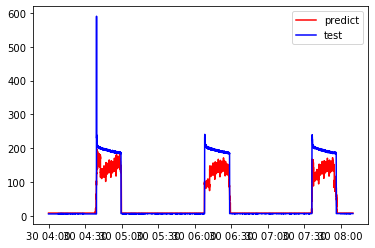

In [162]:
plt.plot(output_datastore_8.get('/fridge_predict').iloc[:15000,:], color = 'red', label = 'predict')
plt.legend()
plt.plot(output_datastore_8.get('/fridge_test').iloc[:15000,:], color = 'blue', label = 'test')
plt.legend()

**CORRELACIÓN CRUZADA**

In [311]:
#Calculo de correlación cruzada
predict8 = output_datastore_8.get('/fridge_predict')
test8 = output_datastore_8.get('/fridge_test')
print(predict8.shape)
t8 = np.ravel(test8)
p8 = np.ravel(predict8)
print(len(t8))
np.corrcoef(t8,p8)


(746149, 1)
746149


array([[1.        , 0.83563302],
       [0.83563302, 1.        ]])

In [312]:
print(f"Correlación {np.corrcoef(t8,p8)[1,0]}")

Correlación 0.8356330216882936


**Potencia promedio de consumo**

In [313]:
total_consumo_test8 = sum(t8)
promedio_test8 = total_consumo_test8 / len(t8)

total_consumo_pred8 = sum(p8)
promedio_pred8 = total_consumo_pred8 / len(p8)

print(f"Consumo test >>> TOTAL = {total_consumo_test8}         Promedio = {promedio_test8}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred8}                Promedio = {promedio_pred8}")

diferencia_total8 = total_consumo_test8 - total_consumo_pred8
print(f"Diferencias total:    {diferencia_total8}")

diferencia_promedio8 = promedio_test8 - promedio_pred8
print(f"Diferencias promedio: {diferencia_promedio8}")

Consumo test >>> TOTAL = 41746110.0         Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 32671105.70295438                Promedio = 43.78630233767569
Diferencias total:    9075004.297045618
Diferencias promedio: 12.162455886217927


## Tabla resumen de resultados

In [273]:
print(f"Correlación {np.corrcoef(t0,p0)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test0}                   Promedio = {promedio_test0}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred0}            Promedio = {promedio_pred0}")
print(f"Diferencias total:    {diferencia_total0}")
print(f"Diferencias promedio: {diferencia_promedio0}")

Correlación 0.8329002100271483
Consumo test >>> TOTAL = 41746110.0                   Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 35364748.77065284            Promedio = 47.39636288549986
Diferencias total:    6381361.229347162
Diferencias promedio: 8.552395338393758


In [274]:
print(f"Correlación {np.corrcoef(t1,p1)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test1}                  Promedio = {promedio_test1}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred1}           Promedio = {promedio_pred1}")
print(f"Diferencias total:    {diferencia_total1}")
print(f"Diferencias promedio: {diferencia_promedio1}")

Correlación 0.8329002100271483
Consumo test >>> TOTAL = 41746110.0                  Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 35364748.77065284           Promedio = 47.39636288549986
Diferencias total:    6381361.229347162
Diferencias promedio: 8.552395338393758


In [275]:
print(f"Correlación {np.corrcoef(t2,p2)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test2}                   Promedio = {promedio_test2}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred2}             Promedio = {promedio_pred2}")
print(f"Diferencias total:    {diferencia_total2}")
print(f"Diferencias promedio: {diferencia_promedio2}")

Correlación 0.8766978154568824
Consumo test >>> TOTAL = 41746110.0                   Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 47464447.0019809             Promedio = 63.61255862030359
Diferencias total:    -5718337.001980901
Diferencias promedio: -7.663800396409968


In [276]:
print(f"Correlación {np.corrcoef(t3,p3)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test3}                   Promedio = {promedio_test3}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred3}            Promedio = {promedio_pred3}")
print(f"Diferencias total:    {diferencia_total3}")
print(f"Diferencias promedio: {diferencia_promedio3}")

Correlación 0.8595733679881972
Consumo test >>> TOTAL = 41746110.0                   Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 39287004.75410256            Promedio = 52.65302875712835
Diferencias total:    2459105.245897442
Diferencias promedio: 3.2957294667652732


In [277]:
print(f"Correlación {np.corrcoef(t4,p4)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test4}                 Promedio = {promedio_test4}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred4}          Promedio = {promedio_pred4}")
print(f"Diferencias total:    {diferencia_total4}")
print(f"Diferencias promedio: {diferencia_promedio4}")

Correlación 0.8837584839095108
Consumo test >>> TOTAL = 41746110.0                 Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 45120391.22648903          Promedio = 60.471020166868854
Diferencias total:    -3374281.22648903
Diferencias promedio: -4.522261942975234


In [278]:
print(f"Correlación {np.corrcoef(t5,p5)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test5}                Promedio = {promedio_test5}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred5}         Promedio = {promedio_pred5}")
print(f"Diferencias total:    {diferencia_total5}")
print(f"Diferencias promedio: {diferencia_promedio5}")

Correlación 0.8717554667491473
Consumo test >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Consumo pred >>> TOTAL = 34813839.56605143         Promedio = 46.65802616642444
Diferencias total:    6932270.433948569
Diferencias promedio: 9.290732057469178


In [279]:
print(f"Correlación {np.corrcoef(t6,p6)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test6}         Promedio = {promedio_test6}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred6}                Promedio = {promedio_pred6}")
print(f"Diferencias total:    {diferencia_total6}")
print(f"Diferencias promedio: {diferencia_promedio6}")

Correlación 0.8720367700559856
Consumo test >>> TOTAL = 42639163.33209946         Promedio = 57.145641597186966
Consumo pred >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Diferencias total:    893053.3320994601
Diferencias promedio: 1.1968833732933462


In [280]:
print(f"Correlación {np.corrcoef(t7,p7)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test7}         Promedio = {promedio_test7}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred7}                Promedio = {promedio_pred7}")
print(f"Diferencias total:    {diferencia_total7}")
print(f"Diferencias promedio: {diferencia_promedio7}")

Correlación 0.7939292401198401
Consumo test >>> TOTAL = 35148099.69362114         Promedio = 47.10600656654521
Consumo pred >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Diferencias total:    -6598010.306378856
Diferencias promedio: -8.842751657348408


In [281]:
print(f"Correlación {np.corrcoef(t8,p8)[1,0]}")
print(f"Consumo test >>> TOTAL = {total_consumo_test8}         Promedio = {promedio_test8}")
print(f"Consumo pred >>> TOTAL = {total_consumo_pred8}                Promedio = {promedio_pred8}")
print(f"Diferencias total:    {diferencia_total8}")
print(f"Diferencias promedio: {diferencia_promedio8}")

Correlación 0.8356330216882936
Consumo test >>> TOTAL = 32671105.70295438         Promedio = 43.78630233767569
Consumo pred >>> TOTAL = 41746110.0                Promedio = 55.94875822389362
Diferencias total:    -9075004.297045618
Diferencias promedio: -12.162455886217927


# Resumen de Resultados

Consideraciones
- Se han calculado los tiempos para 8.6 días correspondientes a los datos de test
- Se tiene la información de diferencias tomadas para la potencia que es la medida registrada por los medidores de cada dispositivo.
- Un valor negativo en las comparaciones entre la medida de test y la predicha significa que la predicción tomo valores por encima de lo real. 
- Un valor positivo significa que las predicciones calculdas tomaron valores por debajo de la medida real. 

|MODELO|Correlación|Consumo Total Test Watt|Consumo Total Pred Watt|Promedio Test Watt|Promedio Pred Watt|Dif Total Watt|Dif Prom Watt|
|--|--|--|--|--|--|--|--|
|DAE0|0.83|41746110|35364748.77|55.94|47.39|6381361.23|8.55|
|1|0.83|41746110|35364748.77|55.94|47.40|6381361.22|8.55|
|2|**0.88**|41746110|47464447.00|55.94|63.61|-5718337.00|-7.66|
|**3**|0.86|41746110|39287004.75|55.94|52.65|**2459105.25**|**3.30**|
|**4**|**0.88**|41746110|45120391.22|55.94|60.47|**-3374281.23**|**-4.52**|
|5|0.87|41746110|34813839.57|55.94|46.66|6932270.43|9.29|
|**6**|0.87|41746110|42639163.33|55.94|**57.14**|**-893053.33**|**-1.20**|
|7|0.79|41746110|35148099.69|55.94|47.10|6598010.31|8.84|
|8|0.84|41746110|32671105.71|55.94|43.79|9075004.30|12.16|

- De acuerdo a la tabla los modelos con mejores aproximaciones entre los datos predichos y los valores reales o de test corresponden a los modelos **3,4 y 6**
- Los modelos **3 y 4** presentan las mejores correlaciones entre la señal predicha y la señal de test. 
- El modelo con menor diferencia de potencia consumida predicha para el dispositivo es el **6** con un diferencia de **-893,053.33** 
- Este modelo en particular tiene una medida por encima de la potencia real de consumo. 
- Esta diferencia corresponde a un porcentaje de diferencia de **2.14%** entre las dos medidas.